# The credit fraud dataset - Synthesizing the minority class
In this notebook it's presented a practical exercise of how to use the avilable library GANs to synthesize tabular data.
For the purpose of this exercise it has been used the Credit Fraud dataset from Kaggle, that you can find here:https: //www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Install ydata-synthetic lib
#! pip install pip install git+https://github.com/ydataai/ydata-synthetic.git

In [ ]:
import importlib
import sys  

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import VanilllaGAN
from ydata_synthetic.preprocessing.credit_fraud import *

model = VanilllaGAN

In [2]:
#Read the original data and have it preprocessed
data = pd.read_csv('data/creditcard.csv', index_col=[0])

In [3]:
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print('Dataset columns: {}'.format(data_cols))
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
processed_data = data[ sorted_cols ].copy()

Dataset columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [4]:
#Before training the GAN do not forget to apply the required data transformations
#To ease here we've applied a PowerTransformation
data = transformations(data)

#For the purpose of this example we will only synthesize the minority class
train_data = data.loc[ data['Class']==1 ].copy()

print("Dataset info: Number of records - {} Number of varibles - {}".format(train_data.shape[0], train_data.shape[1]))

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_data[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train_data.copy()
fraud_w_classes['Class'] = labels

Dataset info: Number of records - 492 Number of varibles - 30
   count
0    384
1    108


# GAN training

Below you can try to train your own generators using the available GANs architectures. You can train it either with labels (created using KMeans) or with no labels at all. 

Remeber that for this exercise in particular we've decided to synthesize only the minority class from the Credit Fraud dataset.

In [5]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 200+1
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

train_sample = fraud_w_classes.copy().reset_index(drop=True)
train_sample = pd.get_dummies(train_sample, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train_sample.columns if 'Class' in i ]
data_cols = [ i for i in train_sample.columns if i not in label_cols ]
train_sample[ data_cols ] = train_sample[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train_sample[ data_cols ]

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_sample.shape[1], dim]
train_args = ['', epochs, log_step]

In [6]:
#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(train_sample, train_args)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0 [D loss: 0.708469, acc.: 39.06%] [G loss: 0.671636]
generated_data
1 [D loss: 0.685336, acc.: 50.00%] [G loss: 0.663698]
2 [D loss: 0.681000, acc.: 50.00%] [G loss: 0.664978]
3 [D loss: 0.674749, acc.: 50.00%] [G loss: 0.690639]
4 [D loss: 0.672142, acc.: 50.00%] [G loss: 0.732488]
5 [D loss: 0.710015, acc.: 49.61%] [G loss: 0.729122]
6 [D loss: 0.742026, acc.: 48.44%] [G loss: 0.713994]
7 [D loss: 0.737963, acc.: 47.66%] [G loss: 0.742747]
8 [D loss: 0.716681, acc.: 42.97%] [G loss: 0.820718]
9 [D loss: 0.688524, acc.: 53.91%] [G loss: 0.922807]
10 [D loss: 0.662431, acc.: 67.58%] [G loss: 1.039891]
11 [D loss: 0.646946, acc.: 67.97%] [G loss: 1.100324]
12 [D loss: 0.636922, acc.: 64.84%] [G loss: 1.111553]
13 [D loss: 0.655045, acc.: 66.02%] [G loss: 1.035249]
14 [D loss: 0

In [7]:
#Generator discription
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 32)]               0         
_________________________________________________________________
dense (Dense)                multiple                  4224      
_________________________________________________________________
dense_1 (Dense)              multiple                  33024     
_________________________________________________________________
dense_2 (Dense)              multiple                  131584    
_________________________________________________________________
dense_3 (Dense)              multiple                  15390     
Total params: 184,222
Trainable params: 184,222
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Discriminator description
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 30)]               0         
_________________________________________________________________
dense_4 (Dense)              multiple                  15872     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  131328    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  32896     
_________________________________________________________________
dense_7 (Dense)              multiple                  129 

In [10]:
#You can easily save the trained generator and loaded it aftwerwards
synthesizer.save('./saved/gan', 'generator_fraud')

AssertionError: Please provide a valid path. Path must be a directory.

In [9]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

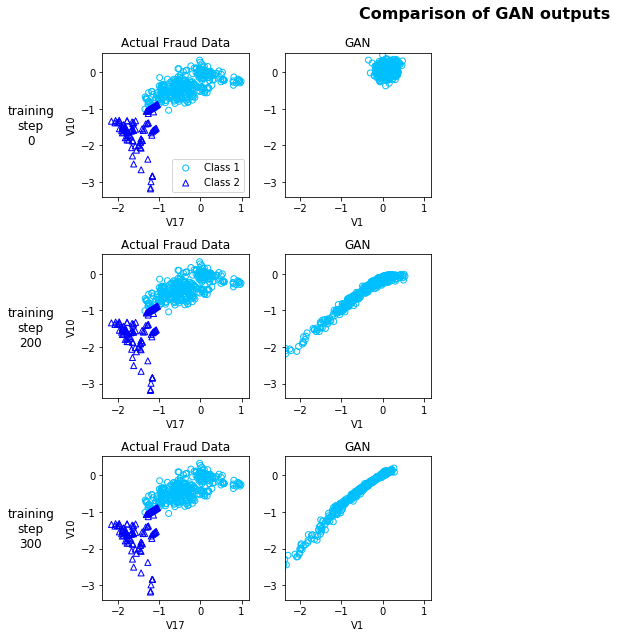

In [11]:
# Setup parameters visualization parameters
seed = 17
test_size = 492 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=train_sample, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols+label_cols)
labels = fraud_w_classes['Class']

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache/'

#Actual fraud data visualization
model_steps = [ 0, 200, 300]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip(real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):

        [model_name, with_class, generator_model] = models[model_name]

        generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols+['label'])
            gen_samples.to_csv('Generated_sample.csv')
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')
